# <font  color = "#0093AF">$T_1$ and Nuclear Overhauser Effect</font>

We previously simulated $T_1$ and NOE in [solution state](../Chapter2/Ch2_T1_NOE.ipynb). In solution NMR, our motion should result in full averaging of the anisotropic interactions. In contrast, in solid-state NMR, no tumbling occurs, so anisotropic interactions remain and influence the resulting spectrum. This also means that different orientations in the sample undergo relaxation with different rate constants. We will characterize this behavior here, and how it depends on the presence or absence of magic angle spinning.

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## $T_1$ anisotropy under static conditions

### Build the system
We use a two-spin $^1$H–$^{15}$N system, with parameters for the H–N in a  protein backbone. We include a 1 ns correlation time, and recovery to thermal equilibrium (`L.add_relax('DynamicThermal')`).

In [3]:
delta=sl.Tools.dipole_coupling(.102,'15N','1H')
hop=40*np.pi/180
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=0,LF=True,pwdavg=7)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex1=ex0.copy()
ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,hop,0]])
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,hop,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-9)
_=L.add_relax('DynamicThermal')

### Propagate and plot

We assume the system starts out with the $^{15}$N spin having been saturated, but thermal polarization on the $^1$H. Note that if a thermalized Liouvillian is used, then the initial magnetization is automatically scaled by the polarization of the system.

In [4]:
seq=L.Sequence(Dt=1e-2)
U=seq.U()
rho=sl.Rho('1Hz','15Nz')

_=rho.DetProp(U,n=10000)

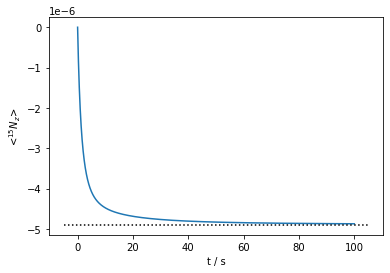

In [5]:
ax=rho.plot(axis='s')
_=ax.plot(ax.get_xlim(),np.ones(2)*ex0.Peq[0],color='black',linestyle=':')

Then, the $^{15}$N magnetization relaxes towards its thermal equilibrium. Note that we observe both a fairly fast component at the beginning ($T_1$~1 s), but also a much slower component, with $T_1$ on the order of 10 s.

We can analyze the multiexponentiality precisely with SLEEPY, as done below.

### Histogram of all rate constants present

SLEEPY gives us the ability to extract individual rate constants from propagators, given a starting density matrix, via the `rho.extract_decay_rates` function. This function has a few modes, but the `'wt_rates'` mode yields a list of rate constants and their corresponding amplitudes, weighted according to the powder average weighting (other modes offer, for example, an averaged weight for each element of the powder average, the average over the full powder average, or a list of rate constants for each element of the powder average; type `help(rho.extract_decay_rates)` for details).

Once we have the rates and amplitudes, we can create a histogram for each weight. Note this is slightly more complex than a usual histogram, because the rate constants have amplitudes associated with them, so we cannot just count up the rate constants in a bin, rather, we need to add together the amplitudes for all rate constants in a bin.

We can also calculate the average rate constant from the rates and amplitudes, shown on the plot.

In [6]:
def histogram(R1,A,bins=None,ax=None):
    if bins is None:
        bins=np.linspace(np.log(R1.min()),np.log(R1.max()),25)
        
    db=bins[1]-bins[0]
    
    i=np.digitize(np.log(R1),bins)-1
    h=np.zeros(len(bins))
    for k in range(i.max()+1):
        h[k]=A[k==i].sum()
        
    if ax is None:
        ax=plt.subplots()[1]
        alpha=1
        color=plt.get_cmap('tab10')(0)
    else:
        alpha=.5    
        color='red'
    ax.bar(bins,h,width=(bins[2]-bins[1])*.9,alpha=alpha,color=color)
    ax.set_xticks(bins[np.arange(5)*5])
    ax.set_xticklabels([f'{10**bins[k:k+2].mean()*1e3:6.2f}' for k in range(0,25,5)])
    ax.set_xlabel(r'$R_1*1e3$ / s$^{-1}$')
    ax.set_ylabel('Intensity')
    
    return bins,ax

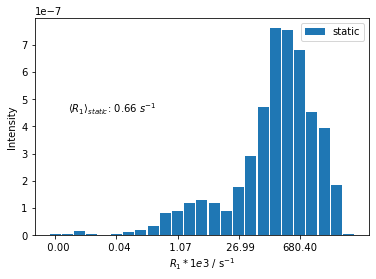

In [7]:
rho.reset()

# Calculate a weighted histogram
R1_static,A_static=rho.extract_decay_rates(U,mode='wt_rates')
bins,ax=histogram(R1_static,A_static)

R1_avg_static=(R1_static*A_static).sum()/A_static.sum()

ax.text(bins[1],4.5e-7,fr'$\langle R_1\rangle_{{static}}$: {R1_avg_static:.2f} $s^{{-1}}$')
_=ax.legend(('static','MAS'))

We see that an extremely broad range of $R_1$ rate constants are obtained, covering several orders of magnitude. These correspond to both different orientations in the powder average, and also different rate constants depending if the dipolar and CSA relaxation are constructive or destructive (see [Trosy Effects](../Chapter2/Ch2_TROSY.ipynb)). 

We now repeat the above calculation, but under magic angle spinning conditions. Note that while we may change `ex0.vr`, we have to take care to clear the Liouvillian cache, also add `n_gamma`, which is set to 1 under static conditions. Newer users may prefer to rebuild the experimental system (`ex0`,`ex1`) and the Liouvillian from scratch, in order to automatically obtain the SLEEPY default settings and avoid mistakes.

## $T_1$ anisotropy under MAS conditions

In [8]:
ex0.vr=10000
ex0.n_gamma=30
L.clear_cache()

ex0.pwdavg=4

seq=L.Sequence()
U=seq.U()**100
rho=sl.Rho('1Hz','15Nz')

_=rho.DetProp(U,n=2000)

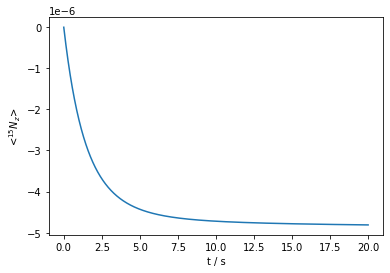

In [9]:
_=rho.plot(axis='s')
_=ax.plot(ax.get_xlim(),np.ones(2)*ex0.Peq[0],color='black',linestyle=':')

The resulting curve appears much less multiexponential than obtained from static conditions, although indeed it is still multiexponential. 

We extract the distribution of relaxation rates for the MAS experiment below, and compare to the distribution under static conditions.

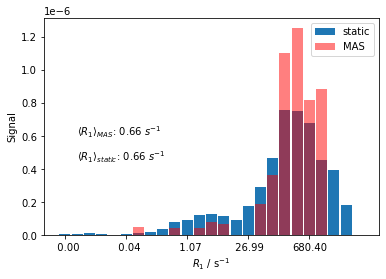

In [10]:
rho.reset()
R1_mas,A_mas=rho.extract_decay_rates(U,mode='wt_rates')

_,ax=histogram(R1_static,A_static,bins=bins)

_,ax=histogram(R1_mas,A_mas,bins=bins,ax=ax)
R1_avg_mas=(A_mas*R1_mas).sum()/A_mas.sum()

ax.text(bins[1],4.5e-7,fr'$\langle R_1\rangle_{{static}}$: {R1_avg_static:.2f} $s^{{-1}}$')
ax.text(bins[1],6e-7,fr'$\langle R_1\rangle_{{MAS}}$: {R1_avg_mas:.2f} $s^{{-1}}$')

ax.legend(('static','MAS'))
ax.set_xlabel(r'$R_1$ / s$^{-1}$')
_=ax.set_ylabel('Signal')

Indeed, the distribution of rate constants under MAS conditions is significantly narrower than under static conditions, although a distribution is still present. The reduction of the breadth of the distribution comes from the fact that as the sample is rotated, different relaxation rate constants are sampled throughout the rotor period, resulting in an average rate constant. However, the rotation does not bring the individual crystallites rate constant resulting from an average over *all* orientations.

Although the width of the distribution changes, its average does not, where both calculations yield $\langle R_1\rangle$=0.66 s (the average $R_1$ must stay the same, the average $T_1$ may, on the other hand, change due to the different distribution width).

## Methyl relaxation

In the next calculation, we investigate relaxation of a $^{13}$C nucleus and the surrounding $^1$H in a methyl group, due to the 3-site methyl hopping dynamics. Approximate methyl correlation time (30 ps) taken from HET-s.$^1$

Methyl hopping represents a special case for exchange simulations, where when a methyl hop (120$^\circ$ rotation) occurs, the new spin-system is identical to the old spin system, except for a change in the spin-indexing. Rather than introducing exchange, which increases the size of the Liouvillian, we may therefore induce exchange within the existing Liouvillian. This is done with the `L.add_SpinEx(...)` function, which requires as input the indices of the spins in exchange and the correlation time of the exchange process as arguments. The resulting Liouvillian is therefore $3\times3=9$ times smaller than if exchange were added via multiple spin-systems in exchange.

[1] K. Zumpfe, M. Berbon, B. Habenstein, A. Loquet, A.A. Smith. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/jacs.3c12620), **2024**, 146, 8164-8178

### Build the system
We introduce a 4-spin, C-H-H-H system, with dipole couplings between all spins, and CSA on the $^{13}$C. Dipole couplings and euler angles are calculated from a tetrahedral geometry with the symmetry axis of the methyl group along the *z*-axis.

In [11]:
ex=sl.ExpSys(700,Nucs=['13C','1H','1H','1H'],LF=True,vr=0,pwdavg=5)
tetra=np.arccos(-1/3)  #Tetrahedral angle (109.47 degrees)
dHC=0.109     #H-C bond length
dHH=2*dHC*np.sin(np.pi-tetra)*np.sin(np.pi/3)  #H-H distance in tetrahedron

deltaHC=sl.Tools.dipole_coupling(dHC,'1H','13C')
deltaHH=sl.Tools.dipole_coupling(dHH,'1H','1H')
ex.set_inter('CSA',i=0,delta=50,euler=[0,np.pi/2,0])
for k in range(1,4):
    ex.set_inter('dipole',i0=0,i1=k,delta=deltaHC,euler=[0,np.pi-tetra,(k-1)*2*np.pi/3])
    for j in range(k+1,4):
        ex.set_inter('dipole',i0=k,i1=j,delta=deltaHH,euler=[0,np.pi/2,2*np.pi*(5/12+2/3*(k-3))])

We add *spin-exchange*, rather than rebuilding the Liouville matrix three times. This approach is only valid if the exchange yields only swapping of positions of the spins.

We also thermalize the Liouvillian, so that it recovers to thermal equilibrium, using `L.add_relax('DynamicThermal')`.

In [12]:
L=ex.Liouvillian()
L.add_SpinEx([1,2,3],tc=30e-12)
_=L.add_relax('DynamicThermal')

Below, we plot the resulting Liouvillian, and also the exchange matrix extracted from the Liouvillian. Note that for technical reasons, the spin-exchange matrix appears in the relaxation matrix (`Lrelax`), rather than in the exchange matrix (`Lex`).

Vertical lines in the Liouvillian plot result from thermalization of the system. The exchange matrix (right), couples states where spins 1, 2, and 3 swap positions (either 1-2-3 goes to 2-3-1 or 3-1-2). For example, the state $|S_0^\alpha S_1^+S_2^-S_3^\beta\rangle$ is coupled to the $|S_0^\alpha S_1^-S_2^\beta S_3^+\rangle$ and $|S_0^\alpha S_1^\beta S_2^+S_3^-\rangle$ states by the exchange matrix.

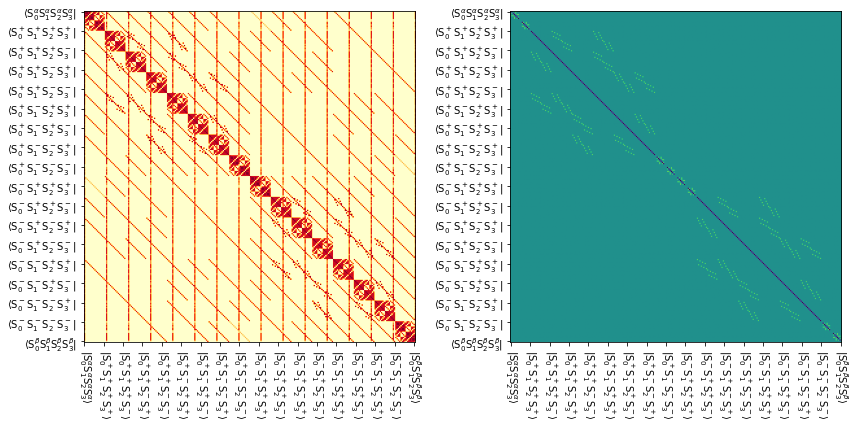

In [13]:
fig,ax=plt.subplots(1,2,figsize=[12,7])
L.plot(ax=ax[0],colorbar=False)
L.plot('Lrelax',mode='re',ax=ax[1],colorbar=False)
fig.tight_layout()

Now we observe the relaxation behavior of the spins, assuming all spins were saturated at the beginning of the measurement.

In [14]:
rho=sl.Rho('zero',['S0z','S1z','S2z','S3z'])

seq=L.Sequence(Dt=.1) #100 ms time step
U=seq.U()
_=rho.DetProp(U,n=100)

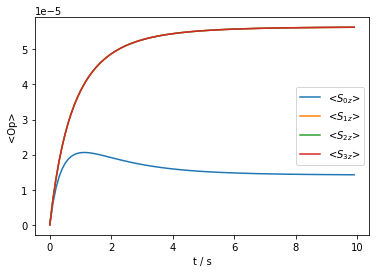

In [15]:
_=rho.plot(axis='s')

We observe a complex relaxation behavior, resulting from coupling of the $^1$H and $^{13}$C relaxation. If we calculate the histogram for this relaxation process, we obtain both positive and negative amplitudes, resulting from the initial buildup of the $^{13}$C relaxation above its thermal equilibrium, followed by decay back to thermal equilibrium. Note that this prevents from easily calculating a meaningful averaged relaxation rate constant.

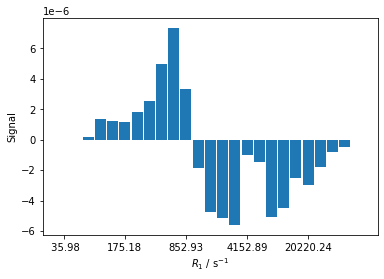

In [16]:
rho.reset()
R1,A=rho.extract_decay_rates(U,mode='wt_rates')

_,ax=histogram(R1,A)

ax.set_xlabel(r'$R_1$ / s$^{-1}$')
_=ax.set_ylabel('Signal')

We can get a less complex behavior by saturating the $^1$H during the recovery. Note that we must use irradiation in the lab-frame irradiation, which is possible with the `sl.LFrf` class.

In [17]:
rho=sl.Rho('zero',['S0z','S1z','S2z','S3z'])

seq=L.Sequence(Dt=0.1).add_channel('1H',v1=25000)
U=sl.LFrf(seq).U()

_=rho.DetProp(U,n=100)

LF calculation: |██████████████████████████████| 100% complete
Completed


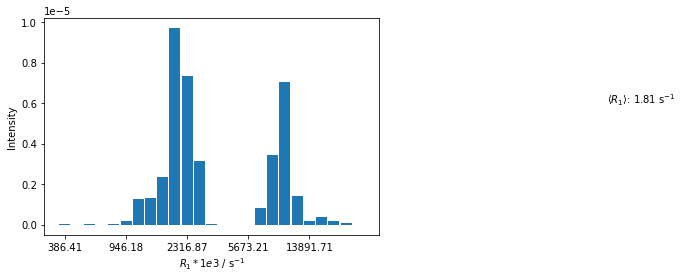

In [18]:
rho.reset()
R1,A=rho.extract_decay_rates(U,mode='wt_rates')

_,ax=histogram(R1,-A)
    
R1_avg=(A*R1).sum()/A.sum()
    
_=ax.text(3,6e-6,fr'$\langle R_1\rangle$: {R1_avg:.2f} s$^{{-1}}$')

The distribution is narrowed, and negative components are eliminated. We plot the buildup, and compare the resulting curve to a monoexpential curve with the averaged relaxation rate constant.

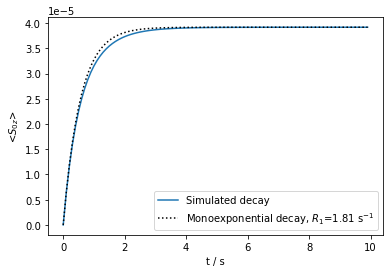

In [19]:
ax=rho.plot(axis='s',det_num=0)
ax.plot(rho.t_axis,rho.I[0][-1].real*(1-np.exp(-rho.t_axis*R1_avg)),color='black',linestyle=':')
_=ax.legend((r'Simulated decay',fr'Monoexponential decay, $R_1$={R1_avg:.2f} s$^{{-1}}$'))

By saturating the $^1$H, we get a narrower distribution of correlation times in the $^{13}$C recovery. Deviation from the monoexponential curve is fairly limited.